In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import KBinsDiscretizer

from collections import defaultdict
import matplotlib.pyplot as plt
df = pd.read_csv(r"C:\Users\syedz\Downloads\archive (13)\traffic_data_combined.csv")
print(df.head())
print(df.shape)


   scenario_intersections  time_step  intersection_id  action  P_0  P_1  P_2  \
0                       2          0                0       0    0    0    1   
1                       2          0                1       0    0    0    0   
2                       2          1                0       1    0    0    0   
3                       2          1                1       1    0    1    1   
4                       2          2                0       0    0    0    1   

   P_3  P_4  P_5  ...  D_8  D_9  D_10  D_11  L_0  L_1  L_2  L_3  M_0  M_1  
0    0    1    0  ...    3    5     1     8  0.0  0.0  1.0  0.0    3    6  
1    1    1    1  ...    4    2     0     9  0.0  0.0  1.0  0.0    3   16  
2    1    1    0  ...    8    3     4     0  0.0  0.0  0.0  1.0    3    3  
3    1    0    0  ...    7    8     1     1  0.0  0.0  1.0  0.0    0    8  
4    0    0    1  ...    5    7     2     0  0.0  1.0  0.0  0.0   15    5  

[5 rows x 982 columns]
(4000, 982)


In [6]:
delay_cols = [c for c in df.columns if c.startswith("D_")]
df["reward"] = -df[delay_cols].sum(axis=1)

print(df[["reward"]].head())

   reward
0     -57
1     -49
2     -50
3     -50
4     -43


In [7]:
print(df.columns)

Index(['scenario_intersections', 'time_step', 'intersection_id', 'action',
       'P_0', 'P_1', 'P_2', 'P_3', 'P_4', 'P_5',
       ...
       'D_9', 'D_10', 'D_11', 'L_0', 'L_1', 'L_2', 'L_3', 'M_0', 'M_1',
       'reward'],
      dtype='object', length=983)


In [8]:
from sklearn.preprocessing import KBinsDiscretizer

# Use all numeric features except the derived reward as inputs to discretize
feature_cols = [c for c in df.columns if c != "reward"]
X = df[feature_cols].to_numpy()

discretizer = KBinsDiscretizer(
    n_bins=5,
    encode='ordinal',
    strategy='uniform'
)

X_disc = discretizer.fit_transform(X).astype(int)

print(X_disc[:5])

[[0 0 0 ... 0 0 1]
 [0 0 1 ... 0 0 4]
 [0 0 0 ... 4 0 0]
 [0 0 1 ... 0 0 2]
 [0 0 0 ... 0 3 1]]


In [ ]:
# Represent state as a tuple of discretized feature values (no giant dense table)
def get_state_tuple(state_vector):
    return tuple(int(s) for s in state_vector)

# Helper function to convert delays to state tuple
def delays_to_state_tuple(delays):
    # Convert delays list to a tuple for use as state
    return tuple(int(d) for d in delays)


In [ ]:
actions = [0, 1, 2]  # 0 = no change, 1 = increase green, 2 = decrease green
n_actions = len(actions)


In [ ]:
class TrafficEnvironment:
    def __init__(self, delays):
        self.original_delays = delays.copy()  # initial snapshot
        self.reset()
    
    def reset(self):
        self.current_delays = self.original_delays.copy()
        self.step_count = 0
        return self.current_delays
    
    def step(self, action):
        # Simple effect of actions:
        # Increase green → reduce delays a little
        # Decrease green → increase delays a little
        if action == 1:  # increase green
            self.current_delays = [max(d - np.random.randint(1, 5), 0) for d in self.current_delays]
        elif action == 2:  # decrease green
            self.current_delays = [d + np.random.randint(1, 5) for d in self.current_delays]
        # 0 = no change → keep delays same

        # Reward = less delay is better
        reward = -sum(self.current_delays)

        self.step_count += 1
        # end episode after 4 steps
        done = self.step_count >= 4
        return self.current_delays, reward, done

# -------------------------------
# 6. Q-learning setup
# -------------------------------
Q = defaultdict(float)

episodes = 20000
alpha = 0.1
gamma = 0.99
epsilon = 0.1
epsilon_decay = 0.95

rewards_per_episode = []

# Use first row of delays as initial environment
initial_delays = df[delay_cols].iloc[0].tolist()
env = TrafficEnvironment(initial_delays)

# -------------------------------

In [17]:
for ep in range(episodes):
    state = delays_to_state_tuple(env.reset())
    total_reward = 0
    done = False

    while not done:
        # Epsilon-greedy action
        if np.random.rand() < epsilon:
            action = np.random.choice(actions)
        else:
            action = actions[np.argmax([Q[(state, a)] for a in actions])]

        # Take action in environment
        next_delays, reward, done = env.step(action)
        next_state = delays_to_state_tuple(next_delays)

        # Q-learning update
        best_next_q = max(Q[(next_state, a)] for a in actions)
        Q[(state, action)] += alpha * (reward + gamma * best_next_q - Q[(state, action)])

        state = next_state
        total_reward += reward

    # Decay epsilon
    epsilon *= epsilon_decay

    rewards_per_episode.append(total_reward)
    print(f"Episode {ep + 1}: Total Reward = {total_reward}")

# -------------------------------

NameError: name 'episodes' is not defined

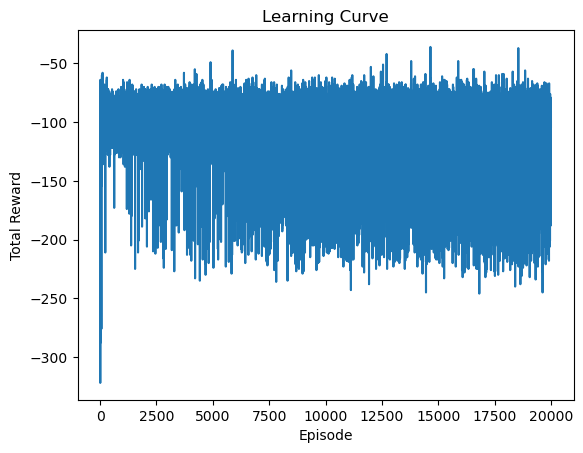

In [39]:
plt.plot(rewards_per_episode)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Learning Curve")
plt.show()
